In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pnd
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import pydotplus
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor

In [37]:
path = "C:/Users/Diego/PycharmProjects/MD/"

carreras = pnd.read_excel(path + "carreras2017.xlsx")
empleabilidad = pnd.read_excel(path + "empleabilidadingresos2017.xlsx")

new_names_empleabilidad = empleabilidad.columns.values
new_names_carreras = carreras.columns.values
new_names_empleabilidad[1] = 'Nombre institución'

for i in range(len(new_names_empleabilidad)):
    new_names_empleabilidad[i] = new_names_empleabilidad[i].strip().lower().replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n")
for i in range(len(new_names_carreras)):
    new_names_carreras[i] = new_names_carreras[i].strip().lower().replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n")
    
empleabilidad.columns = new_names_empleabilidad
carreras.columns = new_names_carreras

carreras['nombre_institucion'] = carreras['nombre_institucion'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())
carreras['nombre_carrera'] = carreras['nombre_carrera'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())

carreras['id'] = carreras['nombre_institucion'] + '-' + carreras['nombre_carrera']

# Quitar espacios y tildes, dejar todo en mayúscula
empleabilidad['nombre_institucion'] = empleabilidad['nombre_institucion'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())
empleabilidad['nombre_carrera'] = empleabilidad['nombre_carrera'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())

empleabilidad['id'] = empleabilidad['nombre_institucion'] + '-' + empleabilidad['nombre_carrera']

In [4]:
print("Atributos empleabilidad:\n",empleabilidad.keys())
print("Atributos carreras:\n", carreras.keys())

print(len(carreras['id'].unique()))
print(len(empleabilidad['id'].unique()))

print(carreras['promedio_psu_2016_de_matricula_1er_ano_2016'].dtype)

Atributos empleabilidad:
 Index(['tipo_de_institucion', 'nombre_institucion', 'area',
       'acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)',
       'nombre_carrera', '%_alumnos_de_establecimientos_subvencionados',
       'retencion_1er_ano', 'duracion_real_(semestres)',
       'empleabilidad_al_1er_ano', 'ingreso_promedio_al_4°_ano_de_titulacion',
       'nombre_carrera_generica', 'ingreso_promedio_al_4°_ano', 'id'],
      dtype='object')
Atributos carreras:
 Index(['nombre_institucion', 'nombre_carrera', 'arancel_anual_2017',
       'costo_de_titulacion', 'duracion_formal', 'nivel_carrera',
       'matricula_1er_ano__femenina_2016', 'matricula_1er_ano_masculina_2016',
       'matricula_1er_ano_2016', 'municipal', 'particular_subvencionado',
       'particular_pagado', 'titulacion_femenina_2015',
       'titlacion_masculna_2015', 'titulacion_total_2015',
       'promedio_psu_2016_de_matricula_1er_ano_2016',
       'promedio_nem_2016_de_matricula_2016', 'id'],
      

In [5]:
filtrado = carreras[carreras['matricula_1er_ano_2016'] > 0]
filtrado = filtrado.fillna(0)

filtrado_empleabilidad = empleabilidad[empleabilidad['ingreso_promedio_al_4°_ano'] > 0]
filtrado_empleabilidad = filtrado_empleabilidad.fillna(0)

del filtrado['nombre_carrera']
del filtrado['nombre_institucion']
del filtrado_empleabilidad['nombre_carrera']
del filtrado_empleabilidad['nombre_institucion']

def acreditacion(valor):
    if valor == 'No':
        return 0
    return int(valor[0])

def sueldos(valor):
    if 0 <= valor <= 650000:
        return 0
    elif 650000 < valor <= 950000:
        return 1
    elif 950000 < valor <= 1250000:
        return 2
    elif 1250000 < valor <= 1550000:
        return 3
    elif 1550000 < valor <= 1850000:
        return 4
    elif 1850000 < valor <= 2150000:
        return 5
    else:
        return 6
    
def empleabilidad(valor):
    if valor < 0.6:
        return 0

filtrado_empleabilidad['acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)'] = \
filtrado_empleabilidad['acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)'].apply(acreditacion)
filtrado_empleabilidad['ingreso_promedio_al_4°_ano'] = filtrado_empleabilidad['ingreso_promedio_al_4°_ano'].apply(sueldos)

filtrado_c = filtrado.copy()
filtrado_empleabilidad_c = filtrado_empleabilidad.copy()

llaves = filtrado.keys()
for j in range(len(llaves)):
    if filtrado[llaves[j]].dtype == 'int64' or filtrado[llaves[j]].dtype == 'float64':
        continue
    if llaves[j] in ['id']:
        continue
    values = filtrado[llaves[j]].unique()
    dic = {}
    for i in range(len(values)):
        dic[values[i]] = i

    filtrado[llaves[j]] = filtrado[llaves[j]].apply(lambda x: dic[x])
    
llaves = filtrado_empleabilidad.keys()
for j in range(len(llaves)):
    if filtrado_empleabilidad[llaves[j]].dtype == 'int64' or filtrado_empleabilidad[llaves[j]].dtype == 'float64':
        continue
    if llaves[j] in ['id']:
        continue
    values = filtrado_empleabilidad[llaves[j]].unique()
    dic = {}
    for i in range(len(values)):
        dic[values[i]] = i

    filtrado_empleabilidad[llaves[j]] = filtrado_empleabilidad[llaves[j]].apply(lambda x: dic[x])
    
# empleabilidad: acreditacion, tipo, area, del %weas, 

agrupado = filtrado.groupby(['id'])
final = agrupado.agg({'arancel_anual_2017' : np.mean,
                      'costo_de_titulacion' : np.mean,
                      'duracion_formal' : np.mean,
                      'matricula_1er_ano__femenina_2016' : np.sum,
                      'matricula_1er_ano_masculina_2016' : np.sum,
                      'matricula_1er_ano_2016' : np.sum,
                      'titulacion_femenina_2015' : np.sum,
                      'titlacion_masculna_2015' : np.sum,
                      'titulacion_total_2015' : np.sum,
                      'municipal' : np.mean,
                      'particular_subvencionado' : np.mean,
                      'particular_pagado' : np.mean,
                      'promedio_psu_2016_de_matricula_1er_ano_2016' : np.mean,
                      'promedio_nem_2016_de_matricula_2016' : np.mean,
                      'nivel_carrera' : np.mean
                     }).reset_index()
print(len(filtrado['id'].unique()))
print(len(final))

2891
2891


In [6]:
filtrado_c.to_excel("filtrado_carreras.xlsx")
filtrado_empleabilidad_c.to_excel("filtrado_empleabilidad.xlsx")

fusion_c = pnd.merge(filtrado_empleabilidad_c, filtrado_c, on='id', how='inner')

fusion_c.to_excel("filtrado_fusion.xlsx")

In [6]:
print(final['nivel_carrera'].unique())
print(filtrado_empleabilidad['acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)'].unique())

[1 0]
[3 0 6 4 5 7 2]


In [32]:
fusion = pnd.merge(filtrado_empleabilidad, filtrado, on='id', how='inner')

ag = fusion.groupby(['id'])
ds = ag.first().copy()
print(ds.keys())

y = ds['ingreso_promedio_al_4°_ano']
y2 = ds['empleabilidad_al_1er_ano']
del ds['ingreso_promedio_al_4°_ano']
del ds['ingreso_promedio_al_4°_ano_de_titulacion']
del ds['empleabilidad_al_1er_ano']
X = ds
print(X.keys())

Index(['tipo_de_institucion', 'area',
       'acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)',
       '%_alumnos_de_establecimientos_subvencionados', 'retencion_1er_ano',
       'duracion_real_(semestres)', 'empleabilidad_al_1er_ano',
       'ingreso_promedio_al_4°_ano_de_titulacion', 'nombre_carrera_generica',
       'ingreso_promedio_al_4°_ano', 'arancel_anual_2017',
       'costo_de_titulacion', 'duracion_formal', 'nivel_carrera',
       'matricula_1er_ano__femenina_2016', 'matricula_1er_ano_masculina_2016',
       'matricula_1er_ano_2016', 'municipal', 'particular_subvencionado',
       'particular_pagado', 'titulacion_femenina_2015',
       'titlacion_masculna_2015', 'titulacion_total_2015',
       'promedio_psu_2016_de_matricula_1er_ano_2016',
       'promedio_nem_2016_de_matricula_2016'],
      dtype='object')
Index(['tipo_de_institucion', 'area',
       'acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)',
       '%_alumnos_de_establecimientos_su

In [40]:
llaves = y2.unique()
llaves.sort()
print(llaves)

[ 0.26507538  0.26923077  0.29010239  0.33333333  0.33910891  0.363047
  0.36363636  0.36619718  0.36898396  0.38150289  0.39150943  0.3988764
  0.40728477  0.4140625   0.42290749  0.42647059  0.43085881  0.43137255
  0.43512974  0.44347826  0.44491525  0.45625     0.46296296  0.4704698
  0.47949527  0.48186528  0.48314607  0.49579832  0.5         0.50869565
  0.51724138  0.51785714  0.52222222  0.52747253  0.53146853  0.53296703
  0.53448276  0.53571429  0.53703704  0.53846154  0.53939394  0.54181185
  0.54424779  0.54474097  0.54545455  0.54847645  0.55078125  0.55491329
  0.55555556  0.55737705  0.55925156  0.56326531  0.56628057  0.56643357
  0.57        0.57009346  0.57317073  0.57352941  0.57427938  0.57534247
  0.57777778  0.58020478  0.58354756  0.58762887  0.59090909  0.59183673
  0.596       0.59624413  0.59633028  0.5974026   0.60084034  0.60897436
  0.60984848  0.61267606  0.615625    0.61870504  0.6255144   0.62790698
  0.63091483  0.63207547  0.63313609  0.63400236  0.635

In [27]:
clf = tree.DecisionTreeClassifier()

cross_val_score(clf, X, y, cv=5)

array([ 0.38815789,  0.54966887,  0.58666667,  0.50684932,  0.57931034])

In [28]:
clf = clf.fit(X, y)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('tree.png')

True

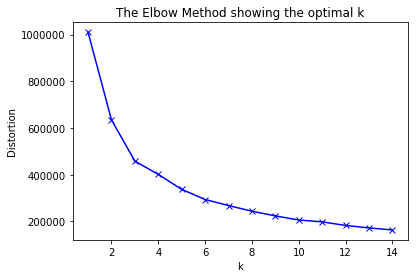

In [29]:
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [45]:
clf = RandomForestClassifier(criterion='entropy')
clf.fit(X, y)
print("Random forest para ingresos:\n")
for i in range(len(X.keys())):
    print(X.keys()[i], ':', clf.feature_importances_[i])
    
clf2 = RandomForestRegressor(criterion='mse')
clf2.fit(X, y2)

print("\nRandom forest para empleabilidad:\n")
for i in range(len(X.keys())):
    print(X.keys()[i], ':', clf2.feature_importances_[i])



Random forest para ingresos:

tipo_de_institucion : 0.00340065392058
area : 0.0932956320457
acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016) : 0.01327417793
%_alumnos_de_establecimientos_subvencionados : 0.0575584595386
retencion_1er_ano : 0.0680055996766
duracion_real_(semestres) : 0.0448997603689
nombre_carrera_generica : 0.0733781065682
arancel_anual_2017 : 0.0950144743346
costo_de_titulacion : 0.0230402084325
duracion_formal : 0.0627709449215
nivel_carrera : 0.00221504973624
matricula_1er_ano__femenina_2016 : 0.042277357331
matricula_1er_ano_masculina_2016 : 0.0542401239644
matricula_1er_ano_2016 : 0.0294288053497
municipal : 0.0453396009197
particular_subvencionado : 0.0313289418208
particular_pagado : 0.034491841918
titulacion_femenina_2015 : 0.0369796480253
titlacion_masculna_2015 : 0.0532796819299
titulacion_total_2015 : 0.0362810723373
promedio_psu_2016_de_matricula_1er_ano_2016 : 0.0608100566326
promedio_nem_2016_de_matricula_2016 : 0.0386898022981

Random for

In [63]:
dummy = DummyClassifier()
clf = RandomForestClassifier(criterion='entropy', n_estimators=200)
print('Random forest ingresos:', np.mean(cross_val_score(clf, X, y, cv=10)), "\nDummy:", np.mean(cross_val_score(dummy, X, y, cv=10)))
print('\n')
dummy2 = DummyRegressor()
clf2 = RandomForestRegressor(criterion='mse')
print('Random forest empleabilidad:', cross_val_score(clf2, X, y2, cv=10), "\nDummy:", cross_val_score(dummy2, X, y2, cv=10))

Random forest ingresos: 0.572997874024 
Dummy: 0.207476881796


Random forest empleabilidad: [ 0.3673532   0.40908998  0.46930382  0.59516949  0.41885506  0.47173746
  0.29143069  0.23423263  0.34380666  0.50079996] 
Dummy: [-0.71037078 -0.3255389  -0.00300885 -0.11706903 -0.10761475 -0.15032273
 -0.02091495 -0.26101481 -0.07876439 -0.00664317]
